# Housing Information Melbourne, Australia
Date: 18/11/2020                                            
Version: 1.0


## 1. Introduction
By using a Python code we can integrate several datasets into one single schema and find and fix possible problems in the data. In this case we are going to use 7 different datasets in various formats about housing information in Victoria, Australia. 


## 2. Import libraries

In [2]:
from urllib.request import urlopen # Import HTML Files
from bs4 import BeautifulSoup # Parse HTML Files
import re  # Parse HTML Files
import pandas as pd # Data frames
import tabula # Import PDF Files 
from sklearn.metrics.pairwise import haversine_distances # Calculate distances between coordinates
from math import radians # Calculate distances between coordinates
import shapefile # Read the shapefiles
from shapely.geometry import Point # Identify if a coordinate is in a polygon
from shapely.geometry import shape # Identify if a coordinate is in a polygon
import datetime # Convert string to time stamp
%matplotlib inline
from sklearn import preprocessing #Zscore normalization
from sklearn.linear_model import LinearRegression # Linear Regression
import numpy as np # Linear Regression
from matplotlib import pyplot as plt
import math
from sklearn.metrics import mean_squared_error, r2_score

## 3. Data Integration

### 3.1. Importing and parsing the data

The first step is to import the files in diferent formats to build one data frame with all the information required. In the folder `./dataframes` we find 5 data frames that must be integrated as follows:

### 3.1.1. Hospitals
We must import the data frame that stores the `id`, `latitude`, `longitude` and `name` of hospitals in **HTML** format 

In [3]:
with open("./data/dataframes/hospitals.html", 'r') as f:
    html = f.read()

Then we convert the text imported in a `BeautifulSoup` object to parse it as follows

In [4]:
bs_html = BeautifulSoup(html, "html.parser") # Convert the text to a BeautifulSoup object

# Header
bs_header = bs_html.find("thead").findAll("th") # With thead we get the header and with th all the objects of the header
header = [] # Empty list to store the objects of the header
for i in bs_header: # For every object parsed
    header.append(i.get_text()) # Remove the <th> </th> tags

header = header[1:] # Remove the first object <th> as it is empty

# Body
bs_body = bs_html.find("tbody").findAll("tr") # With tbody we get the body and with tr all the objects of the body
hospital_id = [] # Empty list to store the hospital ids
hospital_lat = [] # Empty list to store the hospital latitudes
hospital_lng = [] # Empty list to store the hospital longitudes
hospital_name = [] # Empty list to store the hospital names

for i in bs_body: # For every hospital found in the body
    hospital = i.findAll("td") # With td we can find all the objects of a hospital  
    
    hospital_id.append(hospital[0].get_text()) # id is the first object of hospital
    hospital_lat.append(float(hospital[1].get_text())) # lat is the second object of hospital is float format
    hospital_lng.append(float(hospital[2].get_text())) # lng is the thrid object of hospital is float format
    hospital_name.append(hospital[3].get_text()) # name is the fourth object of hospital

# Build the Pandas data frame with a dictionary
hospitals = pd.DataFrame.from_dict({'id' : hospital_id, 'lat': hospital_lat, 'lng': hospital_lng, 'name': hospital_name})
hospitals.head(5)

,id,lat,lng,name
0,hospital_001,-37.990622,145.072836,Como Private Hospital
1,hospital_002,-37.855469,145.268183,Mountain District Private Hospital
2,hospital_003,-37.792230,144.889128,Western Hospital
3,hospital_004,-37.756042,145.061896,Mercy Hospital for Women
4,hospital_005,-37.760623,144.815624,Sunshine Hospital


### 3.1.2. Real State 
`JSON format`  

We must import the data frame that stores the `id`, `latitude`, `longitude` and `name` of properties in JSON format

In [5]:
with open("./data/dataframes/real_state.json", 'r') as f:
    json = f.read()

Then we parse the text imported and then convert it into a pandas data frame as follows

In [6]:
json = eval(json) # Parse the text and convert it to python code 
real_state_json = pd.DataFrame.from_dict(json) # Convert the text to a pandas data frame
real_state_json.head(5)

,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space
0,66416,-37.777223,145.323512,44 Struan Avenue,7245000,house,2014,5,3,2
1,87138,-37.915859,145.006836,802 Hampton Street,9360000,house,2008,3,2,2
2,22656,-37.741057,144.956240,35 Vincent Street,10880000,house,2014,2,1,1
3,31842,-37.736872,145.026830,13 Rita Street,5390000,house,2011,3,1,0
4,26528,-37.571915,144.921423,32 Cradle Mountain Drive,7748000,house,2016,4,2,2


`XML format`  

First, we import the data frame that stores the `id`, `latitude`, `longitude` and `name` of properties in XML format

In [7]:
with open("./data/dataframes/real_state.xml", 'r') as f:
    xml = f.read()
xml = xml[2:] # Remove the first two elements

Then we convert the text imported in a `BeautifulSoup` object to parse it as follows. By taking a closer look to the information parsed, we realised that it has the same structure as the data frame `real_state_json`. Therefore, we are going to reuse the header of this data set.

In [8]:
bs_xml = BeautifulSoup(xml, "xml") # Convert the text to a BeautifulSoup object
property_id = [] # Empty list to store all the ids of the properties

for i in bs_xml.findAll(re.compile(r"n\d*")): # The id of each property is n and five numbers
    property_id.append(i.name) # Get each property_id

property_id = list(set(property_id)) # Remove duplicates 
properties = [] # Empty list to store all the dictionaries of each property

for i in property_id: # For every property
    property_ = bs_xml.findAll(i) # Find all the attibutes of the propertywith this id
    property_dict = {} # Empty dictionary to store the properties with its attributes
    
    for j in range(len(property_)): # For every element of the property_ list
        if property_[j].attrs['type'] == 'int': # If the attribute type is int
            property_dict[list(real_state_json.columns.values)[j]] = int(property_[j].get_text()) # Reuse the header of the last task and append the value as integer
        elif property_[j].attrs['type'] == 'float': # If the attribute type is float
            property_dict[list(real_state_json.columns.values)[j]] = float(property_[j].get_text()) # Reuse the header of the last task and append the value as float
        elif property_[j].attrs['type'] == 'str': # If the attribute type is str
            property_dict[list(real_state_json.columns.values)[j]] = str(property_[j].get_text()) # Reuse the header of the last task and append the value as string
    
    properties.append(property_dict)

After the file is parsed, we proceed to convert the dictionary to a Data Frame

In [9]:
real_state_xml = pd.DataFrame.from_dict(properties) # Convert the text to a pandas data frame
real_state_xml.dropna(inplace=True) # Drop Nan Values
real_state_xml.head(5)

,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space
0,54130.0,-37.828036,145.038611,15 Marian Street,11250000.0,house,2011.0,3.0,2.0,0.0
1,31403.0,-37.761134,145.010090,65 Clyde Street,6810000.0,house,2011.0,2.0,1.0,1.0
2,75224.0,-37.903746,145.060487,5 Boake Street,12480000.0,house,2016.0,5.0,2.0,2.0
3,62523.0,-37.836108,145.239958,12 Ilford Road,10350000.0,house,2015.0,3.0,2.0,2.0
4,14675.0,-37.746868,144.922015,61 Napier Crescent,8100000.0,house,2012.0,3.0,1.0,3.0


Once the data frame parsed from the `HTML` file and the data frame from `XML` file. We proceed to concatenate both dataframes into one

In [10]:
real_state = pd.concat([real_state_json, real_state_xml])
real_state.reset_index(drop=True, inplace=True) # Reset index from 0
real_state.head(5)

,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space
0,66416.0,-37.777223,145.323512,44 Struan Avenue,7245000.0,house,2014.0,5.0,3.0,2.0
1,87138.0,-37.915859,145.006836,802 Hampton Street,9360000.0,house,2008.0,3.0,2.0,2.0
2,22656.0,-37.741057,144.956240,35 Vincent Street,10880000.0,house,2014.0,2.0,1.0,1.0
3,31842.0,-37.736872,145.026830,13 Rita Street,5390000.0,house,2011.0,3.0,1.0,0.0
4,26528.0,-37.571915,144.921423,32 Cradle Mountain Drive,7748000.0,house,2016.0,4.0,2.0,2.0


Finally, we verify that the data frames were concatenated

In [11]:
real_state_json.shape[0] + real_state_xml.shape[0] == real_state.shape[0]

True

### 3.1.3. Supermarkets 

We must  import the data frame that stores the `id`, `latitude`, `longitude` and `name` of properties in EXCEL format

In [12]:
supermarkets = pd.read_excel("./data/dataframes/supermarkets.xlsx")
supermarkets.drop('Unnamed: 0', axis=1, inplace=True)
supermarkets.head(5)

,id,lat,lng,type
0,S_001,-37.883978,144.735287,Woolworths
1,S_002,-41.161591,147.514797,Woolworths
2,S_003,-37.984078,145.077167,Woolworths
3,S_004,-37.707023,144.938740,Woolworths
4,S_005,-37.597670,144.938413,Woolworths


### 3.1.4. Shoping Centers

We must  import the data frame that stores the `id`, `latitude`, `longitude` and `name` of properties in PDF format

In [13]:
sc_read = tabula.read_pdf("./data/dataframes/shopingcenters.pdf", pages='all') # Read the PDF file
shoping_centers = sc_read[0] # Create the data frame with the first page

for i in range(1, len(sc_read)): # For ever y page of the PDF file
    shoping_centers = shoping_centers.append(sc_read[i]) # Append every page to the data frame shoping_centers
    
shoping_centers.drop('Unnamed: 0', axis=1, inplace=True) # Drop useless columns
shoping_centers.reset_index(drop=True, inplace=True) # Reset index from 0
shoping_centers.head(5)

,sc_id,lat,lng
0,SC_001,-37.767915,145.041790
1,SC_002,-37.819375,145.171472
2,SC_003,-37.971131,145.089065
3,SC_004,-35.280406,149.132550
4,SC_005,-37.574572,144.920451


### 3.1.5. Melbourne Train Information

#### 3.1.5.1. Trains Stations

We must  import the data frame that stores the `id`, `stop_name`, `stop_short_name`, `latitude` and `longitude` of Train Stations in TXT format

In [14]:
train_stations = pd.read_csv("./data/GTFS - Melbourne Train Information/stops.txt", sep=",")
train_stations.head(5)

,stop_id,stop_name,stop_short_name,stop_lat,stop_lon
0,15351,Sunbury Railway Station,Sunbury,-37.579091,144.727319
1,15353,Diggers Rest Railway Station,Diggers Rest,-37.627017,144.719922
2,19827,Stony Point Railway Station,Crib Point,-38.374235,145.221837
3,19828,Crib Point Railway Station,Crib Point,-38.366123,145.204043
4,19829,Morradoo Railway Station,Crib Point,-38.354033,145.189602


From this data frame we get the `stop_id` of **Flinders Street Railway Station**, that is the station of interest

In [15]:
flinders_id = train_stations.loc[train_stations['stop_name'] == 'Flinders Street Railway Station', 'stop_id'].item()
flinders_id

19854

#### 3.1.5.2. Calendar

We must import the data frame that stores the type of services in TXT format. From this data frame we can identify which routes are available only on weekends, and remove them. As we are only interested in the `average time of travel` on weekdays.  

In [16]:
calendar = pd.read_csv("./data/GTFS - Melbourne Train Information/calendar.txt", sep=",")
calendar.head(5)

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,T2,0,0,0,0,0,1,0,20151009,20151011
1,UJ,0,0,0,0,0,0,1,20151009,20151011
2,T6,0,0,0,0,1,0,0,20151009,20151011
3,T5,1,1,1,1,0,0,0,20151012,20151015
4,T2_1,0,0,0,0,0,1,0,20151016,20151018


After importing this dataframe, we proceed to get the `service_id` of the routes that are available in weekdays as we are interested in the `average time travel` to **Flinders Street** in weekdays. We perform this task with the following transformation

In [20]:
calendar['weekdays'] = calendar[['monday', 'tuesday', 'wednesday', 'thursday', 'friday']].sum(1) # Get only the weekdays of the data frame
service_id = list(calendar.loc[calendar['weekdays'] == 5, 'service_id']) # Get the id of the services that are available all the weekdays

#### 3.1.5.3. Trip

We must import the data frame that stores the `route_id`, `service_id`, `trip_id`, `shape_id` and some other attributes in TXT format.

In [23]:
trips = pd.read_csv("./data/GTFS - Melbourne Train Information/trips.txt", sep=",")
trips.head(5)

,route_id,service_id,trip_id,shape_id,trip_headsign,direction_id
0,2-ALM-F-mjp-1,T0,17067982.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
1,2-ALM-F-mjp-1,T0,17067988.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
2,2-ALM-F-mjp-1,T0,17067992.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
3,2-ALM-F-mjp-1,T0,17067999.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
4,2-ALM-F-mjp-1,T0,17068003.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0


From this data frame we can identify the `trip_id` of the routes that are available only on weekends by using the list `service_id` from the last task. As we are only interested in the `average time of travel` on weekdays.

In [24]:
trips = trips.loc[trips['service_id'].isin(service_id)]
trip_id = list(set(trips.trip_id))

#### 3.1.5.4. Stop Times

We must import the data frame that stores the `trip_id`, `arrival_time`, `departure_time`, `stop_id` and some other attibutes in TXT format.

In [25]:
stop_times = pd.read_csv("./data/GTFS - Melbourne Train Information/stop_times.txt", sep=",")
stop_times.head(5)

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
0,17182517.T2.2-ALM-B-mjp-1.1.H,04:57:00,04:57:00,19847,1,NaN,0,0,0.000000
1,17182517.T2.2-ALM-B-mjp-1.1.H,04:58:00,04:58:00,19848,2,NaN,0,0,723.017818
2,17182517.T2.2-ALM-B-mjp-1.1.H,05:00:00,05:00:00,19849,3,NaN,0,0,1951.735072
3,17182517.T2.2-ALM-B-mjp-1.1.H,05:02:00,05:02:00,19850,4,NaN,0,0,2899.073349
4,17182517.T2.2-ALM-B-mjp-1.1.H,05:04:00,05:04:00,19851,5,NaN,0,0,3927.090952


From this data frame we can identify the `trip_id` of the routes that are available in weekdays and between **7am-9am**. First, by filtering with the list `trip_id` from the last task that are the trips in weekdays.

In [26]:
stop_times = stop_times.loc[stop_times['trip_id'].isin(trip_id)]

Then we filter the data frame by the `departure_time`, we are interested in the trips that departure from 7am

In [27]:
stop_times['dep_hour'] = stop_times['departure_time'].apply(lambda x: int(str(x)[:2]))
stop_times = stop_times.loc[stop_times['dep_hour'] >= 7]

Afterward, we filter the data by the `arrival_time`, we are interested in the trips that arrive until 9am

In [28]:
stop_times['arr_hour'] = stop_times['arrival_time'].apply(lambda x: int(str(x)[:2]))
stop_times = stop_times.loc[stop_times['arr_hour'] < 9]

With all the transformations shown above we have the data frame `stop_times` that stores `trip_id`, `arrival_time`, `departure_time`, `stop_id` and some other attibutes of the trips of the **Melbourne Train** during weekdays between 7am and 9am. Finally, we have to add to this dataframe the column of `route_id` and we get the data frame `train_info` with all the information required of **Melbourne Train**

We do this by a **left join** between `stop_times` and a data frame that tell us the `route_id` of each trip. As follows

In [29]:
route_trip = trips[['trip_id', 'route_id', 'trip_headsign', 'direction_id']] # Create a dataframe to identify the route of each trip
route_trip = route_trip.drop_duplicates(subset=['trip_id'], keep='first') # Remove duplicate trips
train_info = pd.merge(stop_times, route_trip, on='trip_id', how='left') # Create a new data frame with all the information required
train_info.drop(['stop_headsign', 'pickup_type', 'drop_off_type', 'shape_dist_traveled', 'dep_hour', 'arr_hour'], axis=1, inplace=True) # Drop useless columns
train_info.head(5)

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,route_id,trip_headsign,direction_id
0,17068385.T0.2-ALM-F-mjp-1.2.H,07:00:00,07:00:00,19904,9,2-ALM-F-mjp-1,City (Flinders Street),0
1,17068385.T0.2-ALM-F-mjp-1.2.H,07:02:00,07:02:00,19905,10,2-ALM-F-mjp-1,City (Flinders Street),0
2,17068385.T0.2-ALM-F-mjp-1.2.H,07:04:00,07:04:00,19906,11,2-ALM-F-mjp-1,City (Flinders Street),0
3,17068385.T0.2-ALM-F-mjp-1.2.H,07:07:00,07:07:00,19908,13,2-ALM-F-mjp-1,City (Flinders Street),0
4,17068385.T0.2-ALM-F-mjp-1.2.H,07:10:00,07:10:00,19843,14,2-ALM-F-mjp-1,City (Flinders Street),0


### 3.1.6. Suburbs Boundary

We must  import the data frame that stores the `shapes` and the `records` of the suburbs of Victoria in different formats as:
   - `.dbf`
   - `.shp`
   - `.shx`
   - `.prj`

In [30]:
suburbs = shapefile.Reader("./data/vic_suburb_boundary/VIC_LOCALITY_POLYGON_shp") # note, no suffix, all 3 files are used
suburbs

### 3.2. Integrating the data


First we create a new data frame called `df` that will store the final data frame with all the information required. This data set will be the one with the integration of all the data sets

In [31]:
df = real_state

#### 3.2.1. Suburb

The first task is to identify the suburb where the property is located. Before doing it, we have to create the column `suburb` with the default value: **'not available'**

In [32]:
df['suburb'] = 'not available'

To do this we use the library `shapefile` to import the data frame that have the information about the suburbs in Victoria, then we use `shapely` to identify if a coordinate of a property belongs to a shape of a suburb or not. We used the function **contains**, that checks if a Polygon (shape) *contains* a Point (coordinates) as follows

In [33]:
suburbs_shapes = suburbs.shapes() # Get the shapes of the suburb data frame
suburbs_recs = suburbs.records() # Get the records of the suburb data frame

# Property
for index_df, row_df in df.iterrows(): # Iterate every row of df
    property_coord = Point(row_df['lng'], row_df['lat']) # Get the coordinates of each property into a list as Point
    
    # Suburb
    for i in range(len(suburbs_shapes)): # For every shape in the file 
        boundary = shape(suburbs_shapes[i]) # Define the shape of the suburb that we are inspecting as shape

        if boundary.contains(property_coord): # Check if the coordinate is in the suburb
            df.loc[index_df, 'suburb'] = suburbs_recs[i][6] # Get the name of the suburb of the propert
            break # Break the loop of suburb as we already found the suburb of the property

df.head(5)

,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space,suburb
0,66416.0,-37.777223,145.323512,44 Struan Avenue,7245000.0,house,2014.0,5.0,3.0,2.0,MOOROOLBARK
1,87138.0,-37.915859,145.006836,802 Hampton Street,9360000.0,house,2008.0,3.0,2.0,2.0,BRIGHTON
2,22656.0,-37.741057,144.956240,35 Vincent Street,10880000.0,house,2014.0,2.0,1.0,1.0,COBURG
3,31842.0,-37.736872,145.026830,13 Rita Street,5390000.0,house,2011.0,3.0,1.0,0.0,PRESTON
4,26528.0,-37.571915,144.921423,32 Cradle Mountain Drive,7748000.0,house,2016.0,4.0,2.0,2.0,CRAIGIEBURN


#### 3.2.2. Distances and IDs

The first task is to identify which is the closest **Hospital, Supermarket, Shoping Center and Train Station** to each property and the distance to each of them. Before doing it, we have to create the following columns:
   - `Hospital_id`
   - `Distance_to_hospital`
   - `Supermarket_id`
   - `Distance_to_supermarket` 
   - `Shopping_center_id`
   - `Distance_to_sc` 
   - `Train_station_id`  
   - `Distance_to_train_station`

With the default value shown below

In [34]:
df['Hospital_id'] = 'not available'
df['Distance_to_hospital'] = 0
df['Supermarket_id'] = 'not available'
df['Distance_to_supermarket'] = 0
df['Shopping_center_id'] = 'not available'
df['Distance_to_sc'] = 0
df['Train_station_id'] = 'not available'
df['Distance_to_train_station'] = 0

To calculate the distance we are going to use the library `sklearn.metrics.pairwise` and the function **haversine_distance** between the coordinates of each property and each different building, trying to find the shortest distance. 

To do this we are going to iterate over all the properties and comparing the coordinates of it with the coordinates of each `supermarket`, `hospital`, `shoping center` and `train station`, to get the shortest distance to each of them and the id of the building as follows

In [35]:
# Property
for index_df, row_df in df.iterrows(): # Iterate every row of df
    property_coord = [radians(row_df['lat']), radians(row_df['lng'])] # Get the coordinates of each property into a list
    distance_to_hospital = 1000 # Huge distance for first if statement
    distance_to_supermarket = 1000 # Huge distance for first if statement
    distance_to_sc = 1000 # Huge distance for first if statement
    distance_to_train_station = 1000 # Huge distance for first if statement
    # Hospitals
    
    for index_h, row_h in hospitals.iterrows(): # Iterate every row of hospital
        hospital_coord = [radians(row_h['lat']), radians(row_h['lng'])] # Get the coordinates of each hospital into a list
        distance = round(haversine_distances([property_coord, hospital_coord])[0][1]* 6378000/1000, 3) # Get the distance between the hospital and the property
        
        if distance < distance_to_hospital: # If the distance between the property and hospital is smaller than the previous one
            distance_to_hospital = distance # Assign this distance as the new distance between property and hospital
            hospital_id = row_h['id'] # Get the id of the hospital with the shortest distance
            
    # Once we iterate over all the hospitals, we store the shortest distance calculated and the id of the hospital
    df.loc[index_df, 'Hospital_id'] = hospital_id # Change the default value with the value calculated
    df.loc[index_df, 'Distance_to_hospital'] = distance_to_hospital # Change the default value with the value calculated
    
    
    # Supermarkets
    
    for index_sm, row_sm in supermarkets.iterrows(): # Iterate every row of supermarket
        supermarket_coord = [radians(row_sm['lat']), radians(row_sm['lng'])] # Get the coordinates of each supermarket into a list
        distance = round(haversine_distances([property_coord, supermarket_coord])[0][1]* 6378000/1000, 3) # Get the distance between the supermarket and the property
        
        if distance < distance_to_supermarket: # If the distance between the property and supermarket is smaller than the previous one
            distance_to_supermarket = distance # Assign this distance as the new distance between property and supermarket
            supermarket_id = row_sm['id'] # Get the id of the supermarket with the shortest distance
    
    # Once we iterate over all the supermarkets, we store the shortest distance calculated and the id of the supermarket
    df.loc[index_df, 'Supermarket_id'] = supermarket_id # Change the default value with the value calculated
    df.loc[index_df, 'Distance_to_supermarket'] = distance_to_supermarket # Change the default value with the value calculated
    
    
    # Shoping centers
    
    for index_sc, row_sc in shoping_centers.iterrows(): # Iterate every row of shoping_centers
        shoping_centers_coord = [radians(row_sc['lat']), radians(row_sc['lng'])] # Get the coordinates of each shoping center into a list
        distance = round(haversine_distances([property_coord, shoping_centers_coord])[0][1]* 6378000/1000, 3) # Get the distance between the shoping center and the property
        
        if distance < distance_to_sc: # If the distance between the property and shoping center is smaller than the previous one
            distance_to_sc = distance # Assign this distance as the new distance between property and shoping center
            shoping_center_id = row_sc['sc_id'] # Get the id of the shoping center with the shortest distance
    
    # Once we iterate over all the shoping centers, we store the shortest distance calculated and the id of the shoping center
    df.loc[index_df, 'Shopping_center_id'] = shoping_center_id # Change the default value with the value calculated
    df.loc[index_df, 'Distance_to_sc'] = distance_to_sc # Change the default value with the value calculated
    
    
    
    # Train Station
    
    for index_ts, row_ts in train_stations.iterrows(): # Iterate every row of train_stations
        train_stations_coord = [radians(row_ts['stop_lat']), radians(row_ts['stop_lon'])] # Get the coordinates of each train station into a list
        distance = round(haversine_distances([property_coord, train_stations_coord])[0][1]* 6378000/1000, 3) # Get the distance between the train station and the property
        
        if distance < distance_to_train_station: # If the distance between the property and train station is smaller than the previous one
            distance_to_train_station = distance # Assign this distance as the new distance between property and train station
            train_station_id = row_ts['stop_id'] # Get the id of the train station with the shortest distance
    
    # Once we iterate over all the shoping centers, we store the shortest distance calculated and the id of the shoping center
    df.loc[index_df, 'Train_station_id'] = str(train_station_id) # Change the default value with the value calculated
    df.loc[index_df, 'Distance_to_train_station'] = distance_to_train_station # Change the default value with the value calculated
    
    
df.head(5)

,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space,suburb,Hospital_id,Distance_to_hospital,Supermarket_id,Distance_to_supermarket,Shopping_center_id,Distance_to_sc,Train_station_id,Distance_to_train_station
0,66416.0,-37.777223,145.323512,44 Struan Avenue,7245000.0,house,2014.0,5.0,3.0,2.0,MOOROOLBARK,hospital_113,3.233,S_168,2.069,SC_084,2.284,19877,1.287
1,87138.0,-37.915859,145.006836,802 Hampton Street,9360000.0,house,2008.0,3.0,2.0,2.0,BRIGHTON,hospital_156,1.417,S_009,0.976,SC_046,3.818,19951,0.929
2,22656.0,-37.741057,144.956240,35 Vincent Street,10880000.0,house,2014.0,2.0,1.0,1.0,COBURG,hospital_084,1.464,S_172,0.794,SC_030,1.103,19965,0.641
3,31842.0,-37.736872,145.026830,13 Rita Street,5390000.0,house,2011.0,3.0,1.0,0.0,PRESTON,hospital_090,2.040,S_225,1.342,SC_047,0.359,20011,2.318
4,26528.0,-37.571915,144.921423,32 Cradle Mountain Drive,7748000.0,house,2016.0,4.0,2.0,2.0,CRAIGIEBURN,hospital_104,8.770,S_178,2.697,SC_005,0.308,40221,3.848


#### 3.2.3. Trips to Flinders Station

The first task is to set a Boolean attribute indicating whether there is a direct trip to the **Flinders Street Station** from the closest station and the second one is to calculate the average travel time in minutes from the closest train station to
the **Flinders Street Station**. Both tasks must be calculated on weekdays departing between 7 to 9 am.

To perform these tasks we have to create the columns `Transfer_flag` and `travel_min_to_CBD` with the default values shown below.

In [37]:
df['Transfer_flag'] = -1
df['travel_min_to_CBD'] = 0

Then to identify if there is a direct trip to **Flinders** we are going to use the data frame `stop_times`. If a trip stops is the *closest station to the property* and then in *Flinders Street Railway Station* the value of `Transfer_flag` will be 0, otherwise will be 1. Finally, we have to calculate the `average travel time` from this station to flinders (minutes). To do this we have to get the time that takes every trip from the *closest train station* to **Flinders Street Station** and get the average of those trips, as follows

In [38]:
# Property
for index_df, row_df in df.iterrows(): # Iterate every row of df
    closets_train_station = row_df.Train_station_id # Get the id of the closets train stration to the property
    trips = list(set(train_info.loc[train_info['stop_id'] == int(closets_train_station), 'trip_id'])) # Get the trip_id of the trips that stops in the closest trains station
    trip_time = [] # Empty list to store the time of travel from the closest train station to the property to Flinders
    
    # Routes
    for trip in trips: # For every trip that stops in the closest train station
        trips_property = train_info.loc[train_info['trip_id'] == trip, ['trip_id', 'stop_id', 'stop_sequence', 'arrival_time', 'departure_time']] # Get all the information of the trip
        property_station = trips_property.loc[trips_property['stop_id'] == int(closets_train_station), 'stop_sequence'] # Identify the stop number of the closest train station
        flinders_station = trips_property.loc[trips_property['stop_id'] == int(flinders_id), 'stop_sequence'] # Identify the stop number of flinders station
        
        if flinders_station.shape[0] > 0: # If the trip stops in flinders station
            if property_station.item() < flinders_station.item(): # If the trip goes from the closests train station to flinders
                departure = datetime.datetime.strptime(trips_property.loc[trips_property['stop_id'] == int(closets_train_station), 'departure_time'].item(), '%H:%M:%S')
                arrival = datetime.datetime.strptime(trips_property.loc[trips_property['stop_id'] == int(flinders_id), 'arrival_time'].item(), '%H:%M:%S')
                travel_time = (arrival - departure)/60
                trip_time.append(travel_time.seconds) # There is a trip  that goes directly to Flinders
    
    if len(trip_time) == 0:
        df.loc[index_df, 'Transfer_flag'] = 1 # There is no direct trip from the closest station to property to Flinders
    else:
        df.loc[index_df, 'Transfer_flag'] = 0 # There is direct trip from the closest station to property to Flinders
        df.loc[index_df, 'travel_min_to_CBD'] = round(sum(trip_time)/len(trip_time), 3) # Get the average time of a trip 

df.head(5)

,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space,...,Hospital_id,Distance_to_hospital,Supermarket_id,Distance_to_supermarket,Shopping_center_id,Distance_to_sc,Train_station_id,Distance_to_train_station,Transfer_flag,travel_min_to_CBD
0,66416.0,-37.777223,145.323512,44 Struan Avenue,7245000.0,house,2014.0,5.0,3.0,2.0,...,hospital_113,3.233,S_168,2.069,SC_084,2.284,19877,1.287,0,55.250
1,87138.0,-37.915859,145.006836,802 Hampton Street,9360000.0,house,2008.0,3.0,2.0,2.0,...,hospital_156,1.417,S_009,0.976,SC_046,3.818,19951,0.929,0,22.083
2,22656.0,-37.741057,144.956240,35 Vincent Street,10880000.0,house,2014.0,2.0,1.0,1.0,...,hospital_084,1.464,S_172,0.794,SC_030,1.103,19965,0.641,0,28.000
3,31842.0,-37.736872,145.026830,13 Rita Street,5390000.0,house,2011.0,3.0,1.0,0.0,...,hospital_090,2.040,S_225,1.342,SC_047,0.359,20011,2.318,0,29.182
4,26528.0,-37.571915,144.921423,32 Cradle Mountain Drive,7748000.0,house,2016.0,4.0,2.0,2.0,...,hospital_104,8.770,S_178,2.697,SC_005,0.308,40221,3.848,0,45.889


### 4. Exporting the data
Finally, after the integration of these 7 data frames we proceed to export `df` to a .csv file

In [39]:
df.to_csv('output.csv')

### 5. Inspecting the data
The first step is to inspect and analyze the data that is going to be used in the `Linear Model`. For this task we are going to use the data frame created in the last task but only the following columns: `price`, `Distance_to_sc`, `travel_min_to_CBD`, and `Distance_to_hospital`

In [45]:
data = df[['Distance_to_sc', 'travel_min_to_CBD', 'Distance_to_hospital', 'price']]
data.head(5)

,Distance_to_sc,travel_min_to_CBD,Distance_to_hospital,price
0,2.284,55.250,3.233,7245000.0
1,3.818,22.083,1.417,9360000.0
2,1.103,28.000,1.464,10880000.0
3,0.359,29.182,2.040,5390000.0
4,0.308,45.889,8.770,7748000.0


From this data frame, we realize that each column is in different unit of measure, `Distance_to_sc` and `Distance_to_hospital` are in *Kilometers* (km), `travel_min_to_CBD` is in *Minutes* (m) and `price` is in *Australian Dolars* (AUD). 

Besides that it can be observed that the scale of each column is different as we can see in the following graph and table.

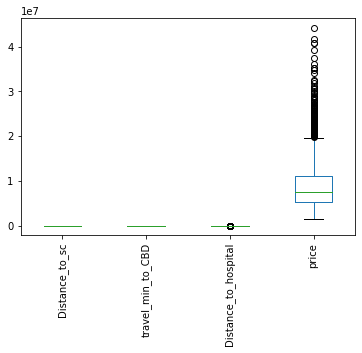

In [46]:
data.plot(kind='box', rot=90)

In [47]:
data.describe()

,Distance_to_sc,travel_min_to_CBD,Distance_to_hospital,price
count,2012.000000,2012.000000,2012.000000,2.012000e+03
mean,2.560174,33.688387,2.287795,9.019079e+06
std,1.375734,12.481128,1.843484,5.652566e+06
min,0.110000,0.000000,0.049000,1.512000e+06
25%,1.483250,23.846000,1.045000,5.268750e+06
50%,2.279000,34.091000,1.735000,7.415000e+06
75%,3.470500,42.273000,2.885250,1.104250e+07
max,5.944000,61.000000,9.368000,4.420000e+07


The columns price is way bigger than the other columns

In [48]:
print('Price is', round(data.price.mean()/data.Distance_to_sc.mean(), 0), 'times bigger than Distance_to_sc')
print('Price is', round(data.price.mean()/data.Distance_to_hospital.mean(), 0), 'times bigger than Distance_to_hospital')
print('Price is', round(data.price.mean()/data.travel_min_to_CBD.mean(), 0), 'times bigger than travel_min_to_CBD')

Price is 3522838.0 times bigger than Distance_to_sc
Price is 3942259.0 times bigger than Distance_to_hospital
Price is 267721.0 times bigger than travel_min_to_CBD


Therefore, we take a closer look to the other three columns: `Distance_to_sc`, `travel_min_to_CBD`, `Distance_to_hospital`

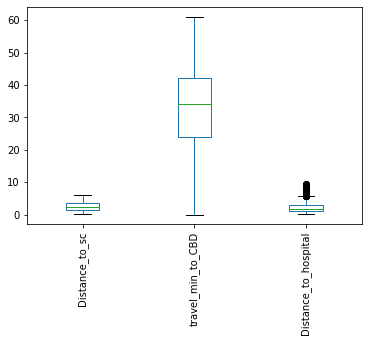

In [49]:
df[['Distance_to_sc', 'travel_min_to_CBD', 'Distance_to_hospital']].plot(kind='box', rot=90)

To realize that travel_min_to_CBD is also bigger than the other two columns

In [50]:
print('travel_min_to_CBD is', round(data.travel_min_to_CBD.mean()/data.Distance_to_sc.mean(), 0), 'times bigger than Distance_to_sc')
print('travel_min_to_CBD is', round(data.travel_min_to_CBD.mean()/data.Distance_to_hospital.mean(), 0), 'times bigger than Distance_to_hospital')

travel_min_to_CBD is 13.0 times bigger than Distance_to_sc
travel_min_to_CBD is 15.0 times bigger than Distance_to_hospital


We have 4 columns to create our `Linear Model` and only two of them *(Distance_to_hospital, Distance_to_sc)*, have the same scale and same unit measure. That is why we require to transform and reshape all the columns to get better results

### 6. Reshaping of the data
Now that we are aware that the data is in diferent scales and units we must reshape the data to make it useful to our model.
There are so many methods of reshaping, but we are going to use two of them: `MinMax` and `Z-Score` Normalisation to reshape each column, and then get the best fit into the model

#### 6.1. Z-Score Normalisation
To do this reshape we are going to use `Scikit-Learn` library and the function `StandardScaler` for standardise data (mean=0, SD=1) as follows


In [51]:
zscore = preprocessing.StandardScaler().fit(data[['Distance_to_sc', 'travel_min_to_CBD', 'Distance_to_hospital', 'price']])
data_std = zscore.transform(df[['Distance_to_sc', 'travel_min_to_CBD', 'Distance_to_hospital', 'price']]) # an array not a df
data_std[0:5]

array([[-0.20079695,  1.72796673,  0.51285507, -0.31393171],
       [ 0.91452169, -0.930066  , -0.47248096,  0.06032764],
       [-1.05946143, -0.45587238, -0.44697943,  0.3292989 ],
       [-1.60039824, -0.36114586, -0.13444993, -0.64218282],
       [-1.63747858,  0.97776791,  3.51715334, -0.22492346]])

With the transformation we proceed to store the results in the `data` data frame 

In [52]:
data['Dis_sc_zscore'] = data_std[:,0] # Distance_to_sc scaled by Zscore
data['travel_CBD_zscore'] = data_std[:,1] # travel_min_to_CBD scaled by Zscore
data['Dis_hos_zscore'] = data_std[:,2] # Distance_to_hospital scaled by Zscore
data['price_zscore'] = data_std[:,3] # price scaled by Zscore
data.head()

<ipython-input-52-7605c87fc5c1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Dis_sc_zscore'] = data_std[:,0] # Distance_to_sc scaled by Zscore
<ipython-input-52-7605c87fc5c1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['travel_CBD_zscore'] = data_std[:,1] # travel_min_to_CBD scaled by Zscore
<ipython-input-52-7605c87fc5c1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

,Distance_to_sc,travel_min_to_CBD,Distance_to_hospital,price,Dis_sc_zscore,travel_CBD_zscore,Dis_hos_zscore,price_zscore
0,2.284,55.250,3.233,7245000.0,-0.200797,1.727967,0.512855,-0.313932
1,3.818,22.083,1.417,9360000.0,0.914522,-0.930066,-0.472481,0.060328
2,1.103,28.000,1.464,10880000.0,-1.059461,-0.455872,-0.446979,0.329299
3,0.359,29.182,2.040,5390000.0,-1.600398,-0.361146,-0.134450,-0.642183
4,0.308,45.889,8.770,7748000.0,-1.637479,0.977768,3.517153,-0.224923


#### 6.2 MinMax Normalisation
To do this transformation we are going to use `Scikit-Learn` library and the function `MinMaxScaler` for standardise data as follows

In [53]:
minmax = preprocessing.MinMaxScaler().fit(data[['Distance_to_sc', 'travel_min_to_CBD', 'Distance_to_hospital', 'price']])
data_minmax = minmax.transform(df[['Distance_to_sc', 'travel_min_to_CBD', 'Distance_to_hospital', 'price']]) # an array not a df
data_minmax[0:5]

array([[0.37264313, 0.9057377 , 0.34166756, 0.13430004],
       [0.6355845 , 0.36201639, 0.14679687, 0.18384558],
       [0.17020912, 0.45901639, 0.15184033, 0.21945277],
       [0.04268084, 0.47839344, 0.21364953, 0.0908452 ],
       [0.03393898, 0.75227869, 0.93583002, 0.14608321]])

With the transformation we proceed to store the results in the `data` data frame 

In [54]:
data['Dis_sc_minmax'] = data_minmax[:,0] # Distance_to_sc scaled by Zscore
data['travel_CBD_minmax'] = data_minmax[:,1] # travel_min_to_CBD scaled by Zscore
data['Dis_hos_minmax'] = data_minmax[:,2] # Distance_to_hospital scaled by Zscore
data['price_minmax'] = data_minmax[:,3] # price scaled by Zscore
data.head()

<ipython-input-54-531215b4b94e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Dis_sc_minmax'] = data_minmax[:,0] # Distance_to_sc scaled by Zscore
<ipython-input-54-531215b4b94e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['travel_CBD_minmax'] = data_minmax[:,1] # travel_min_to_CBD scaled by Zscore
<ipython-input-54-531215b4b94e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

,Distance_to_sc,travel_min_to_CBD,Distance_to_hospital,price,Dis_sc_zscore,travel_CBD_zscore,Dis_hos_zscore,price_zscore,Dis_sc_minmax,travel_CBD_minmax,Dis_hos_minmax,price_minmax
0,2.284,55.250,3.233,7245000.0,-0.200797,1.727967,0.512855,-0.313932,0.372643,0.905738,0.341668,0.134300
1,3.818,22.083,1.417,9360000.0,0.914522,-0.930066,-0.472481,0.060328,0.635585,0.362016,0.146797,0.183846
2,1.103,28.000,1.464,10880000.0,-1.059461,-0.455872,-0.446979,0.329299,0.170209,0.459016,0.151840,0.219453
3,0.359,29.182,2.040,5390000.0,-1.600398,-0.361146,-0.134450,-0.642183,0.042681,0.478393,0.213650,0.090845
4,0.308,45.889,8.770,7748000.0,-1.637479,0.977768,3.517153,-0.224923,0.033939,0.752279,0.935830,0.146083


#### 6.3 Visualization
And now we observe the reshaping in the following graph

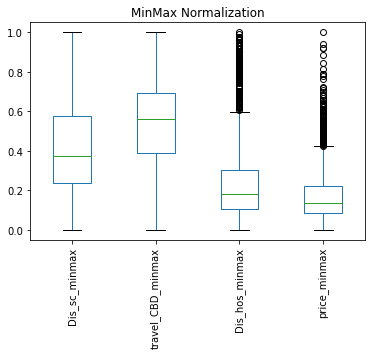

In [55]:
data[['Dis_sc_minmax', 'travel_CBD_minmax', 'Dis_hos_minmax', 'price_minmax']].plot(kind='box', rot=90, title='MinMax Normalization')

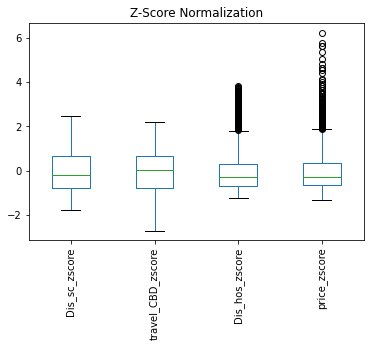

In [56]:
data[['Dis_sc_zscore', 'travel_CBD_zscore', 'Dis_hos_zscore', 'price_zscore']].plot(kind='box', rot=90, title='Z-Score Normalization')

From the boxplots shown above we realise that the columns `price` and `Distance_to_hospital` have some outliers. Therefore, when we use **MinMax** the median of the data is below 0.2 and most of the data is under 0.6. Therefore, we can use **Z-Score** for these two columns. However with the other two columns: `Distance_to_sc` and `travel_min_to_CBD` we are going to use MinMax Normalization, as the data has no outliers and this transformation could give us more meaningful information.

In [57]:
data = data[['Dis_sc_minmax', 'travel_CBD_minmax', 'Dis_hos_zscore', 'price_zscore']]

Finally, we rename the columns but with the new values

In [58]:
data.rename(columns={'Dis_sc_minmax': 'Distance_to_sc', 'travel_CBD_minmax': 'travel_min_to_CBD', 
                     'Dis_hos_zscore': 'Distance_to_hospital', 'price_zscore': 'price'}, inplace=True)
data.head(5)

C:\Users\Ricardo Arias\anaconda3\lib\site-packages\pandas\core\frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,Distance_to_sc,travel_min_to_CBD,Distance_to_hospital,price
0,0.372643,0.905738,0.512855,-0.313932
1,0.635585,0.362016,-0.472481,0.060328
2,0.170209,0.459016,-0.446979,0.329299
3,0.042681,0.478393,-0.134450,-0.642183
4,0.033939,0.752279,3.517153,-0.224923


### 7. Transformation of the data
To build our model the relationship between the predictors and the value to predict must be linear. Therefore, we must find the correct transformation to each predcitor to find the linear correlation between variables as follows. To do this we are going to use a function to find the relationship by a graph.

```python
plt.scatter(x, y, color='blue')
```

#### 7.1 Price vs. Distance_to_sc
From the dataframe `data` we proceed to find the linear relationship 

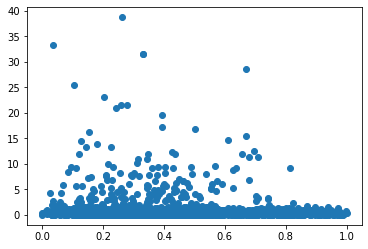

In [59]:
x = data['Distance_to_sc']
y = np.power(data['price'], 2)
plt.scatter(x, y)

With the following graph we find that $\text{price}^2$ has a linear relationship with the Distance to Shopping Center


#### 7.2 Price vs. Distance_to_hospital
From the dataframe `data` we proceed to find the linear relationship 

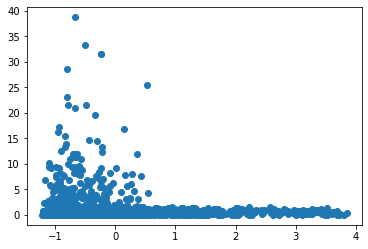

In [60]:
x = data['Distance_to_hospital']
y = np.power(data['price'], 2)
plt.scatter(x, y)

With the following graph we find that $\text{price}^2$ has a linear relationship with $\text{Distance to Hospital}$


#### 7.2 Price vs. Travel_min_to_CBD
From the dataframe `data` we proceed to find the linear relationship 

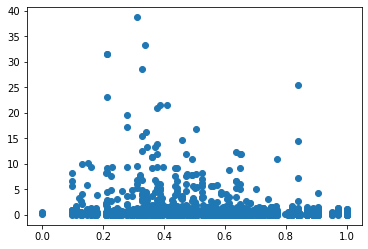

In [61]:
x = data['travel_min_to_CBD']
y = np.power(data['price'], 2)
plt.scatter(x, y)

With the following graph we find that $\text{price}^2$ has a linear relationship with the Travel time to the CBD

### 8. Linear Model
Now that we have our transformations and the same scale in all the columns, we proceed to fit the model with the transformed variables in order to get the model with most reliability.

In [62]:
model_df = data[['Distance_to_sc', 'travel_min_to_CBD', 'Distance_to_hospital']]
model_df['price_to_the_2'] = np.power(data['price'], 2)
model_df.head()

,Distance_to_sc,travel_min_to_CBD,Distance_to_hospital,price_to_the_2
0,0.372643,0.905738,0.512855,0.098553
1,0.635585,0.362016,-0.472481,0.003639
2,0.170209,0.459016,-0.446979,0.108438
3,0.042681,0.478393,-0.134450,0.412399
4,0.033939,0.752279,3.517153,0.050591


To do this first we have to split the data frame `data` in two different data frames. The first one is `train` that is composed with the 70% of rows of `data` and will be used to train the model. The second one is `test` with the other 30% that will be used to test the model

In [63]:
train = model_df.iloc[:int(round((len(model_df)*0.7),0))] # Train data set
test = model_df.iloc[int(round((len(model_df)*0.7),0)):] # Test Data set
true_label = test.price_to_the_2 # True label of the test data set
test = test.drop('price_to_the_2', 1) # Delete the true label from the test data set

In [64]:
y_train = train['price_to_the_2'] # Attribute to predict
x_train = train[['Distance_to_sc', 'travel_min_to_CBD', 'Distance_to_hospital']]

model = LinearRegression().fit(x_train, y_train)
pred_label =  model.predict(test)
print('Coefficient of determination: %.2f'
      % r2_score(true_label, pred_label))

Coefficient of determination: 0.02


With the coefficient of determination equal to 0.02 we understandand that even though there is a linear relation between the variables and the $\text{Price}^2$, there is no correlation between these variables to build the model. 

It could be because the price to the power of two is in most of the cases a value close to 0 so it looks like there is a linear relationship, but there is not. And that is why when we build our model it does not fit quite well

## References

[Import HTML file to Python](https://stackoverflow.com/questions/51794609/how-to-import-html-file-into-python-variable)

[Tag removal in BeautifulSoup](https://stackoverflow.com/questions/15934562/beautifulsoup-tag-removal)

[BeautifulSoup Documentation](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)

[Convert list to a dictionary](https://careerkarma.com/blog/python-convert-list-to-dictionary/#:~:text=Converting%20a%20list%20to%20a,the%20Python%20zip()%20function.)

[Get the name of a tag BeautifulSoup](https://www.kite.com/python/examples/1702/beautifulsoup-get-the-name-of-a-tag)

[Shapely Documentation](https://shapely.readthedocs.io/en/stable/manual.html)

[Add columns to a pandas data frame with default value](https://www.interviewqs.com/ddi_code_snippets/add_new_col_df_default_value)

[Iterating row by row in a pandas data frame](https://stackoverflow.com/questions/23330654/update-a-dataframe-in-pandas-while-iterating-row-by-row/29262040)

[Sum multiple columns in pandas](https://stackoverflow.com/questions/43767905/how-to-sum-3-columns-panda-python)

[Select rows with some condition in pandas](https://www.geeksforgeeks.org/selecting-rows-in-pandas-dataframe-based-on-conditions/)

[Converting strings to datetime format](https://stackabuse.com/converting-strings-to-datetime-in-python/)

[Convert timedelta to integers](https://stackoverflow.com/questions/5522031/convert-timedelta-to-total-seconds)

[Resent index in a data frame in pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html)

[Appending data frames to an empty data frame](https://stackoverflow.com/questions/16597265/appending-to-an-empty-dataframe-in-pandas)

[Export data frames in Pandas to csv file](https://towardsdatascience.com/how-to-export-pandas-dataframe-to-csv-2038e43d9c03)

[Drop NaN values of a row in a pandas data frame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html)